In [87]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%load_ext autoreload
%autoreload 2
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
path_dataset = "data_train.csv"
ratings = load_data(path_dataset)
print('Shape of ratings matrix:',ratings.shape)

number of items: 10000, number of users: 1000
Shape of ratings matrix: (10000, 1000)


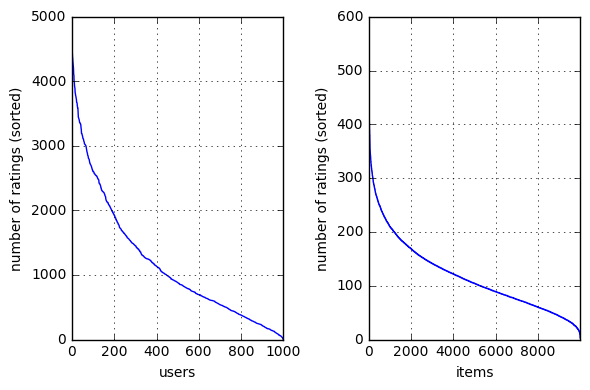

min # of items per user = 8, min # of users per item = 3.


In [89]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [90]:
# # Let's first play with a submatrix
# ratings = ratings[:100,:100]
# print('No of non-zero elements in ratings submatrix:',len(ratings.nonzero()[0]))

In [91]:
def init_MF_random(train, num_features):
    """init the parameter for matrix factorization."""
    
    #     to be returned:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    
    
    item_features = np.random.random((train.shape[0],num_features))  # W matrix initialization
    user_features = np.random.random((train.shape[1],num_features)) # Z matrix initialization
    
    return user_features, item_features

In [92]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    #     to be returned:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    
    train_svd = np.zeros(train.shape)
    for i in range(train.shape[0]):
        for j in range(train.shape[1]):
            train_svd[i,j] = train[i,j]
    
    U, s, V = np.linalg.svd(train_svd, full_matrices=False)
    
    S = np.diag(s)

    U_1 = U[:,0:num_features]
    S_1 = S[0:num_features, 0:num_features]
    V_1 = V[0:num_features, :]
    
    item_features = U_1 # W matrix of the decomposition
    user_features = (S_1.dot(V_1) ).T # Z matrix of the decomposition
    
    
    #raise NotImplementedError
    
    return user_features, item_features

In [93]:
# define parameters
gamma = 0.0009
num_features = 50   # K in the lecture notes
lambda_user = 0.0
lambda_item = 0.0
num_epochs = 120     # number of full passes through the train set
errors = [0]

# set seed
np.random.seed(988)

train = ratings

# init matrix
user_features, item_features = init_MF_random(train, num_features)

# find the non-zero ratings indices 
nz_row, nz_col = train.nonzero()
nz_train = list(zip(nz_row, nz_col))

In [ ]:
real_train_label = np.zeros(len(nz_train))
prediction_train = np.zeros(len(nz_train))
rmse_train = np.zeros(num_epochs)


for it in range(num_epochs): 
    
    print(it)
    # shuffle the training rating indices
    np.random.shuffle(nz_train)

    # decrease step size
    # gamma /= 1.2
    count = 0
    mat_pred = np.dot(item_features,user_features.T)
    begin = datetime.datetime.now()
    print('beginning step 1')
    for d,n in nz_train:
        
        # Updating the W
        d_dash = d
        for k in range(item_features.shape[1]):
            gradient = -1* (train[d,n] - mat_pred[d,n]) * user_features[n,k]
            
            item_features[d_dash,k] = item_features[d_dash,k] - gamma * gradient
         
        # Updating the Z
        n_dash = n
        for k in range(user_features.shape[1]):
            gradient = -1* (train[d,n] - mat_pred[d,n]) * item_features[d,k]
            user_features[n_dash,k] = user_features[n_dash,k] - gamma * gradient
            
    mat_pred = np.dot(item_features,user_features.T)
    print('beginning step 2')
    
    #Calculating training rmse
    for i in range(len(nz_train)):
        real_train_label[i] = train[nz_train[i][0],nz_train[i][1]]
        prediction_train[i] = mat_pred[nz_train[i][0],nz_train[i][1]]
        
    
    
    rmse_train[it] = calculate_mse(real_train_label, prediction_train) 
    
    rmse = rmse_train[it]
    
    print("iter: {}, RMSE on training set: {}.".format(it, rmse))
    end = datetime.datetime.now()
    execution_time = (end - begin).total_seconds()
    print(execution_time)

0
beginning step 1


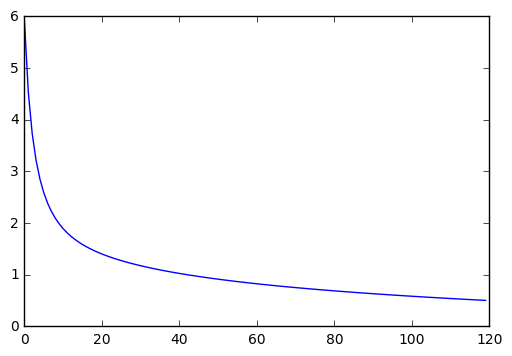

In [86]:
plt.plot(rmse_train)